In [9]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np
import matplotlib.pyplot as plt
from utils import CSVData

%matplotlib inline

In [2]:
class BLOB:
    pass
blob=BLOB()

In [5]:
# Create data loader
from iotools import loader_factory
from iotools.hkdataset import H5Dataset,Collate
from torch.utils.data import DataLoader

class H5DatasetHybrid(H5Dataset):
    
    # def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0, read_keys=[]):
    #     """
    #     Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)
    #           transform ... a function applied to pre-process data 
    #           flavour ..... a string that is required to be present in the filename
    #           limit_num_files ... an integer limiting number of files to be taken per data directory 
    #           start_fraction .... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)
    #           use_fraction ...... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)
    #           read_keys ......... a list of string values = data product keys in h5 file to be read-in (besides 'event_data' and 'labels')
    #     """
    #     self._h5ds = H5Dataset(data_dirs,transform,flavour,limit_num_files,start_fraction,use_fraction,read_keys)
    
    def __len__(self):
        # return int(len(super())/2.)
        return int(super(H5DatasetHybrid, self).__len__()/2.)

    def __getitem__(self,idx):
        e1,l1,x1,i1 = super(H5DatasetHybrid, self).__getitem__(idx)
        e2,l2,x2,i2 = super(H5DatasetHybrid, self).__getitem__(idx+len(self))
        
        largetime = 1e6
        e1[:,:,1] = np.where(e1[:,:,0]>0, e1[:,:,1], largetime)
        e2[:,:,1] = np.where(e2[:,:,0]>0, e2[:,:,1], largetime)
        
        es = e1*0.
        # sum charge
        es[:,:,0] = e1[:,:,0] + e2[:,:,0]
        # take min of time
        # after stack we have [2,H,V], so take min over first index
        es[:,:,1] = np.stack([e1[:,:,1], e2[:,:,1]]).min(0)
        es[:,:,1] = np.where(es[:,:,0]>0, es[:,:,1], 0.)
        
        # labels
        i_none = 0.
        i_rin1 = 1.
        i_rin2 = 1.
        i_both = 2.
        
        ls = np.where(
            e1[:,:,0] > 0,
            np.where(e2[:,:,0] > 0, i_both, i_rin1),
            np.where(e2[:,:,0] > 0, i_rin2, i_none)
        )
        
        return es,ls,x1,i1


def hybrid_loader_factory(batch_size,
                   shuffle=True,
                   num_workers=1,
                   collate_fn=Collate,
                   **args):
    ds = H5DatasetHybrid(**args)
    loader = DataLoader(ds,
                        batch_size  = batch_size,
                        shuffle     = shuffle,
                        num_workers = num_workers,
                        collate_fn  = collate_fn)
    return loader


DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
# for train
blob.train_loader=hybrid_loader_factory(batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)
# for validation
blob.test_loader =hybrid_loader_factory(batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.8, use_fraction=0.2)

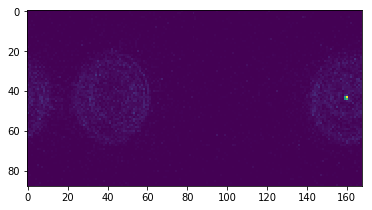

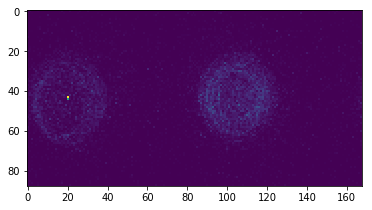

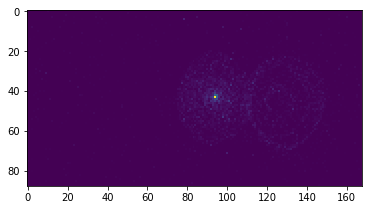

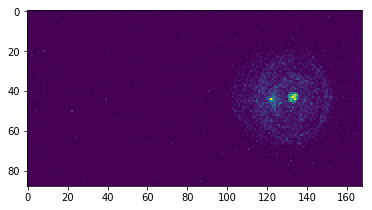

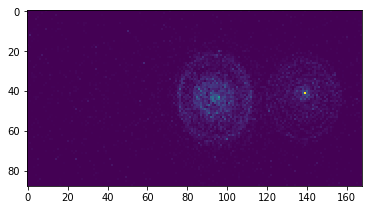

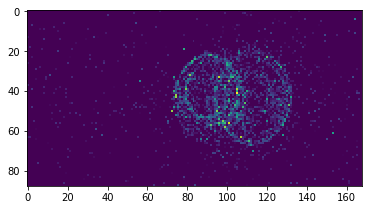

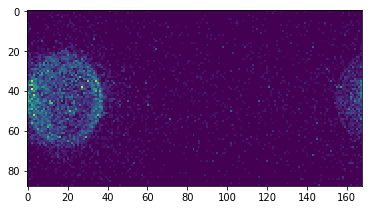

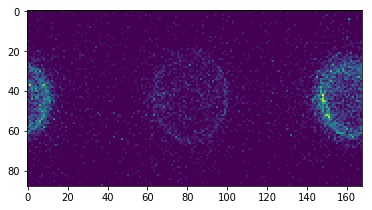

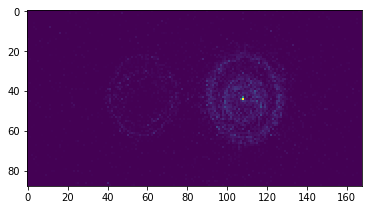

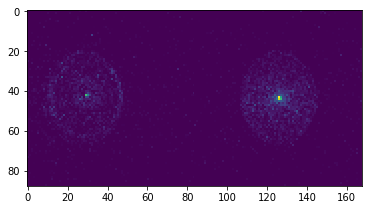

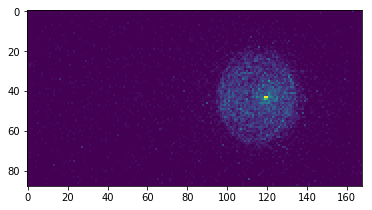

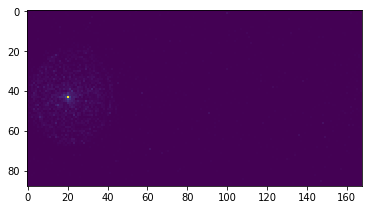

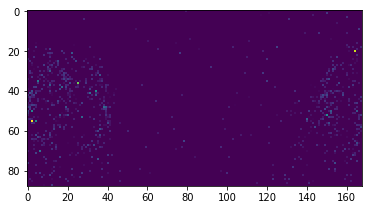

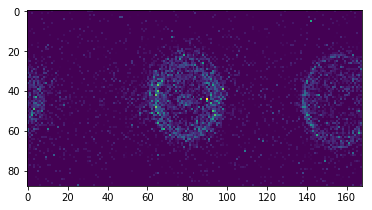

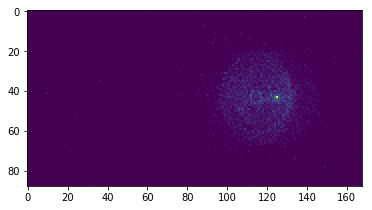

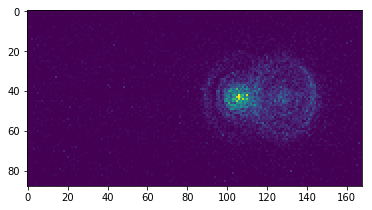

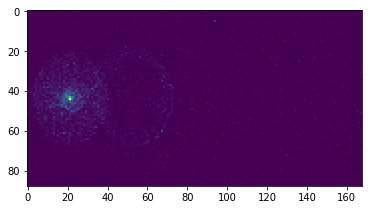

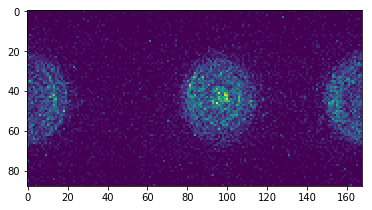

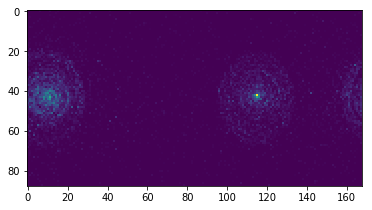

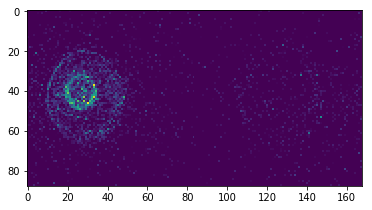

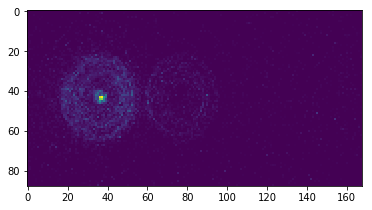

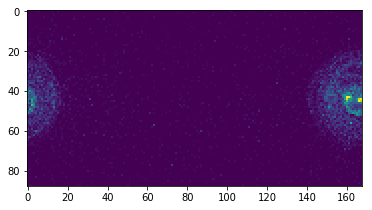

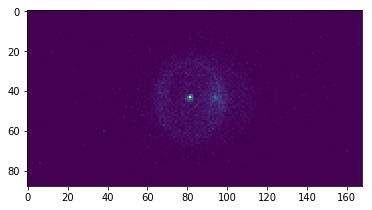

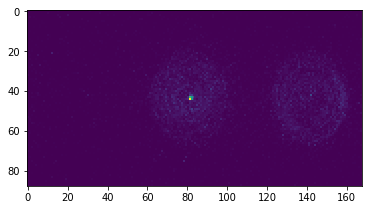

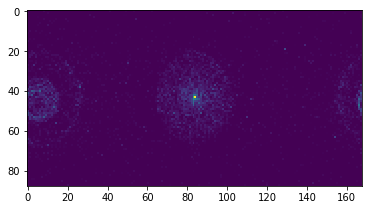

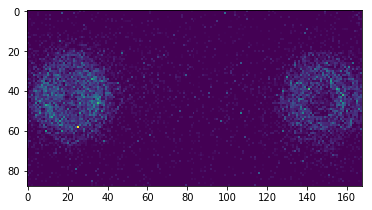

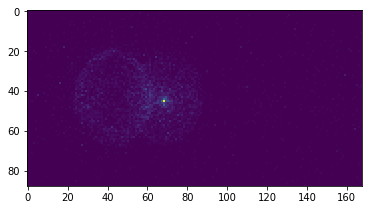

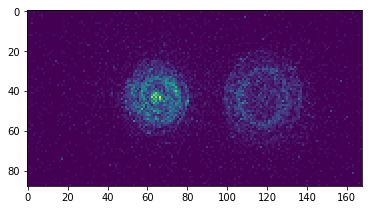

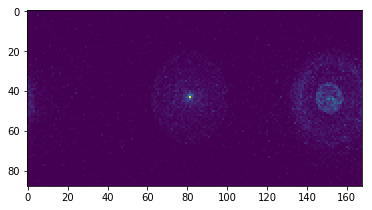

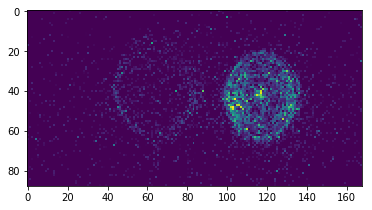

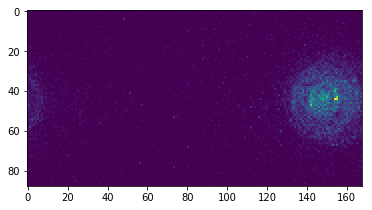

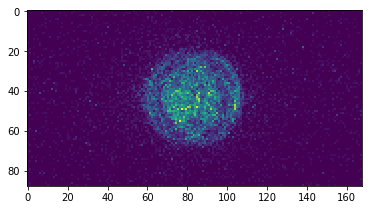

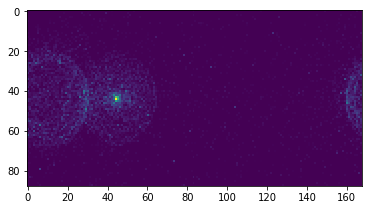

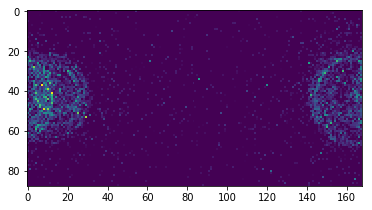

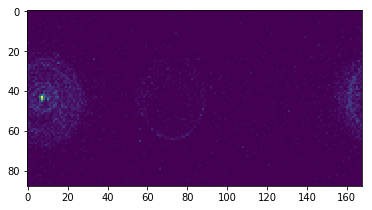

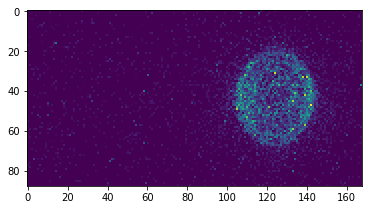

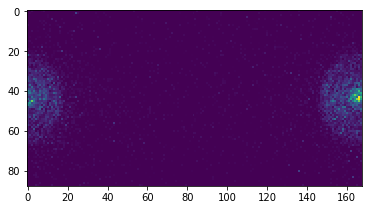

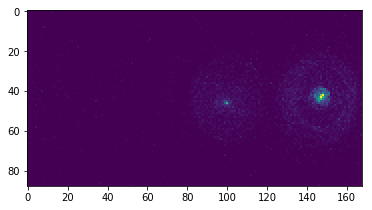

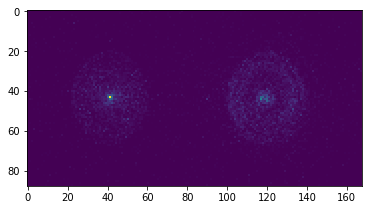

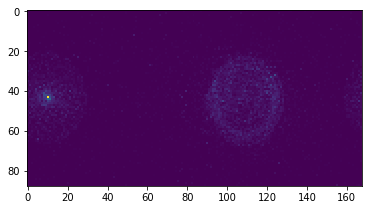

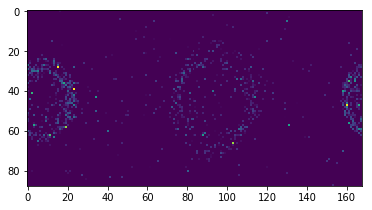

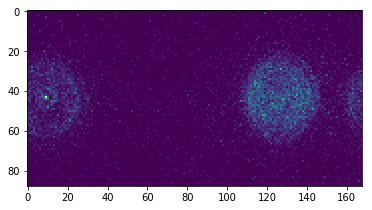

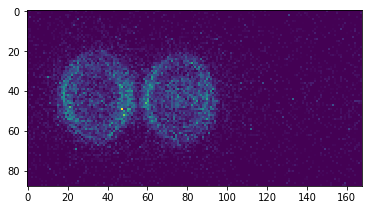

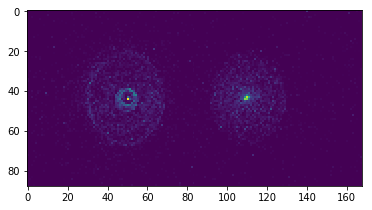

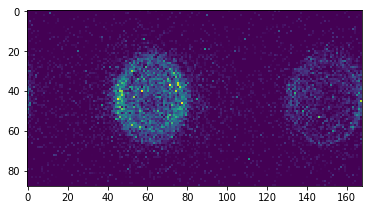

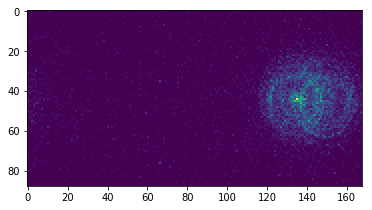

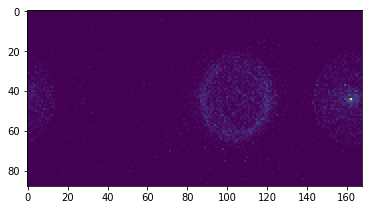

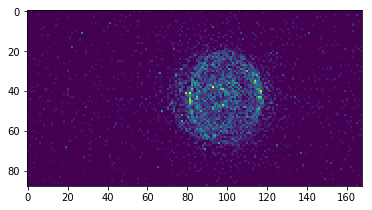

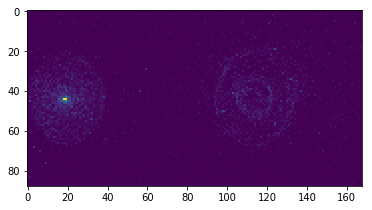

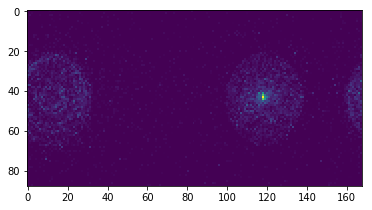

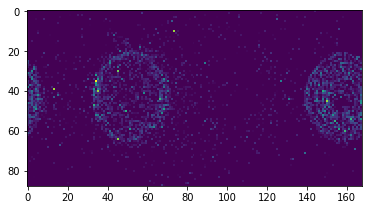

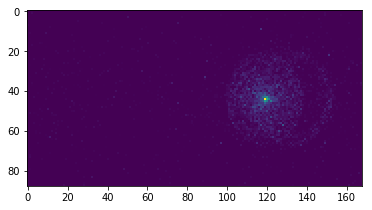

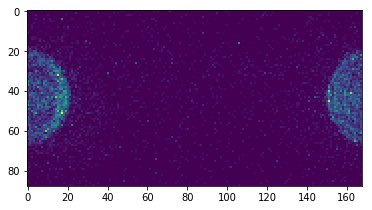

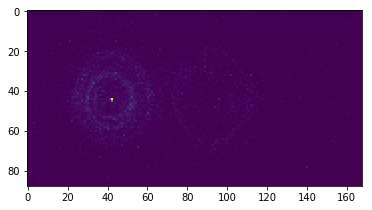

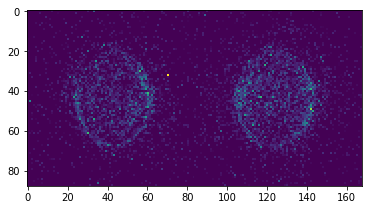

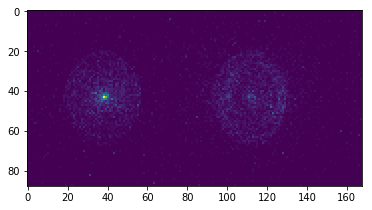

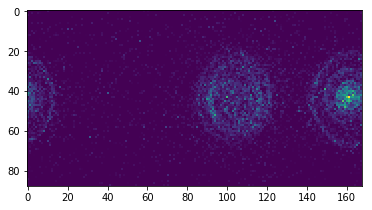

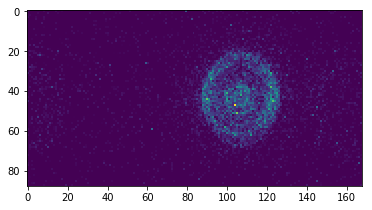

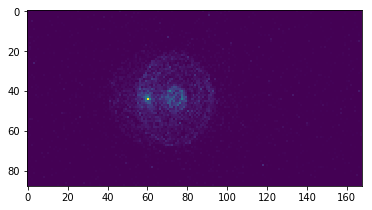

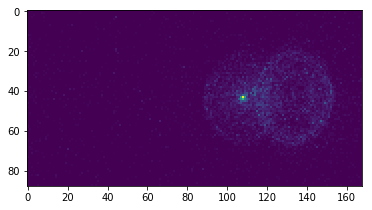

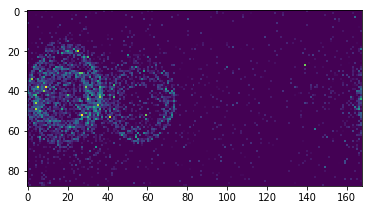

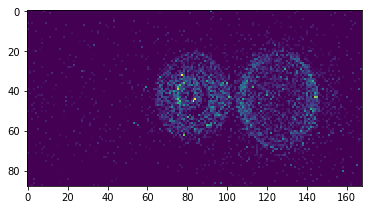

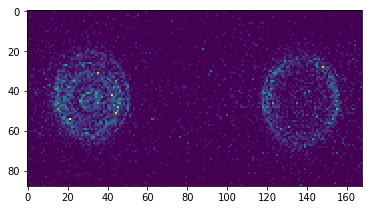

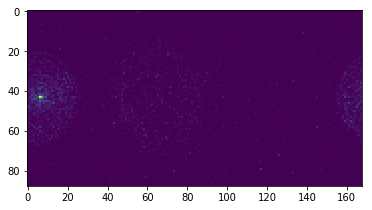

In [6]:
for idx,batch in enumerate(blob.train_loader):
    for idx in np.arange(0,batch[0].shape[0]):
        plt.imshow(batch[0][idx,:,:,0])
        plt.show()
    break

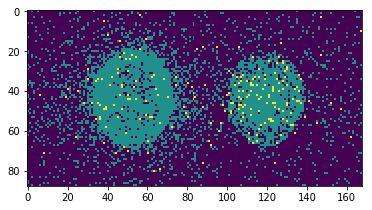

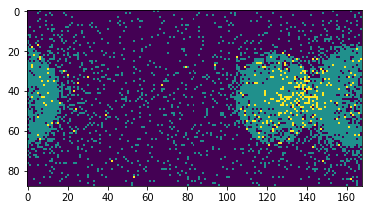

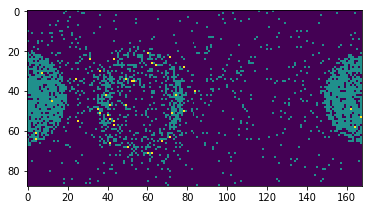

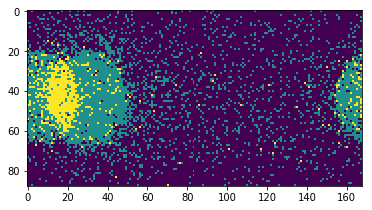

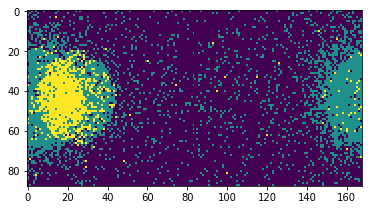

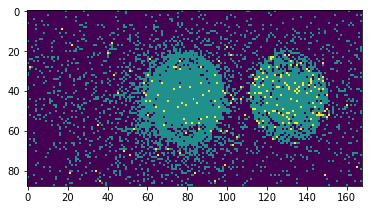

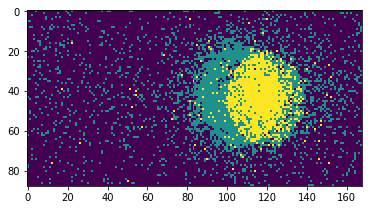

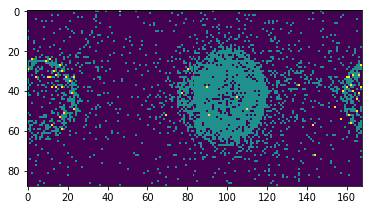

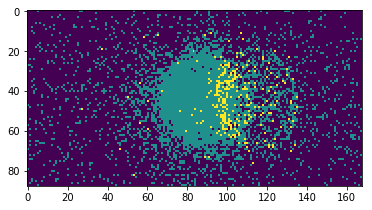

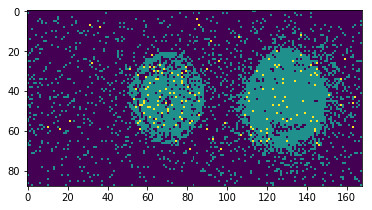

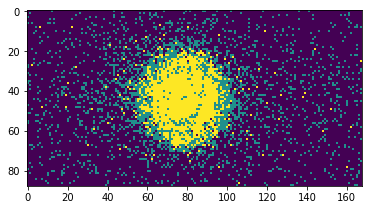

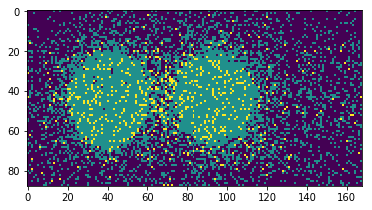

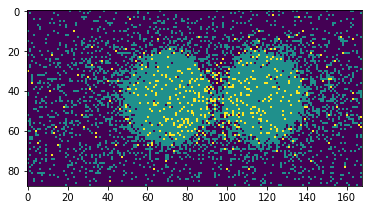

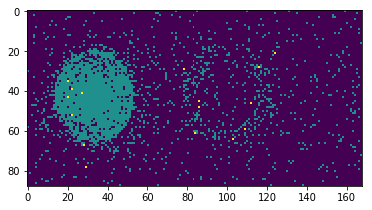

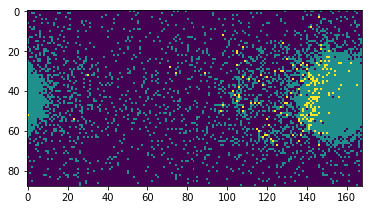

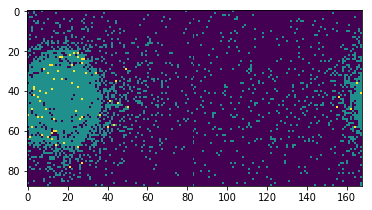

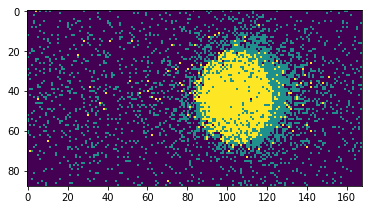

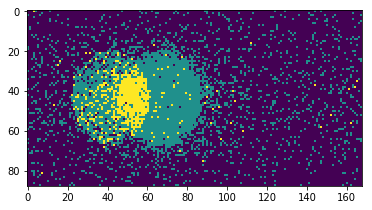

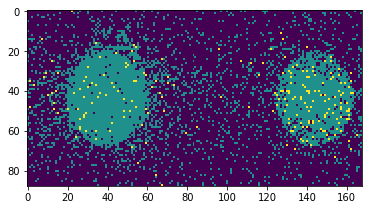

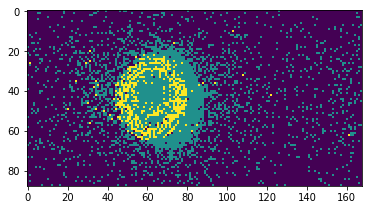

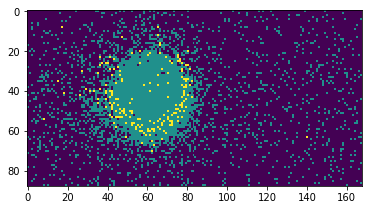

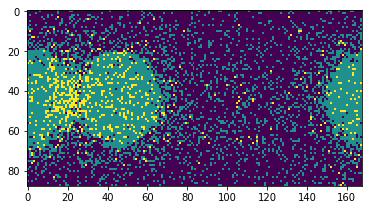

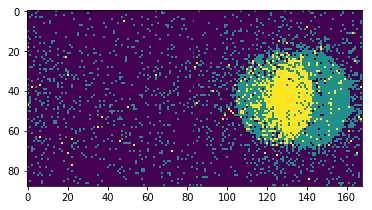

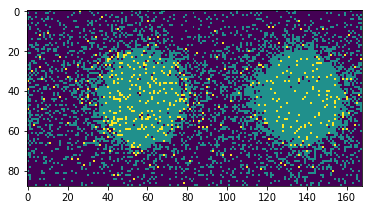

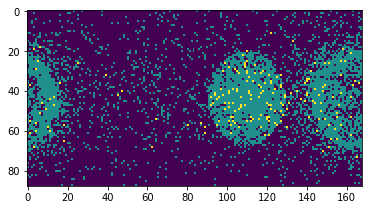

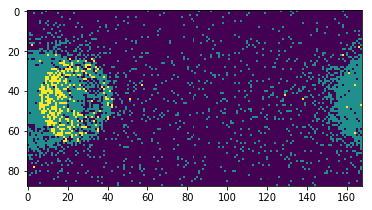

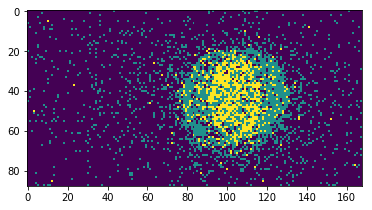

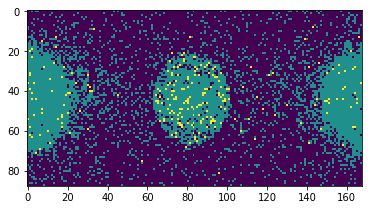

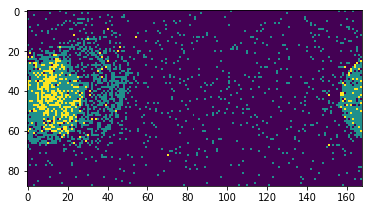

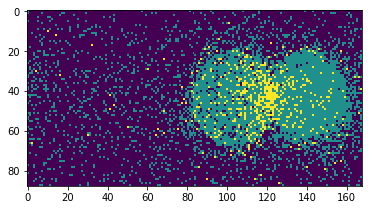

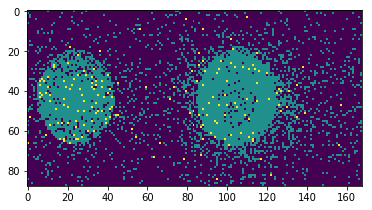

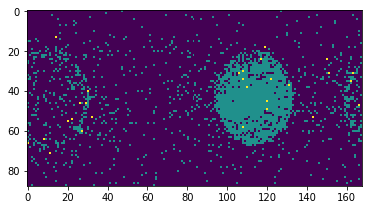

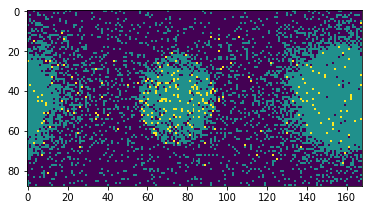

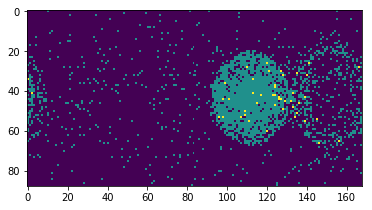

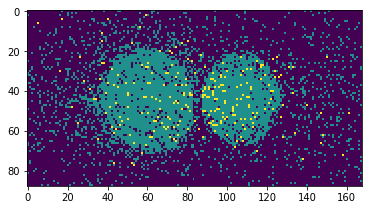

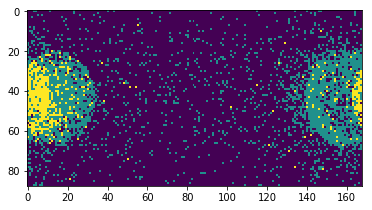

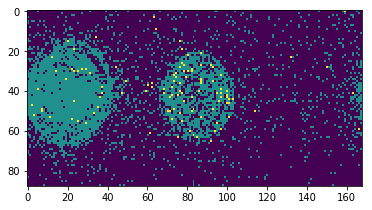

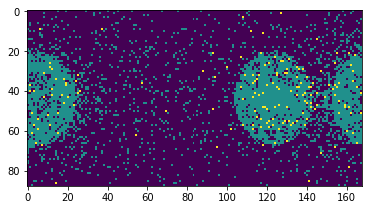

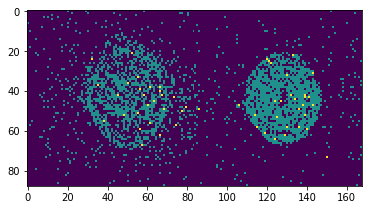

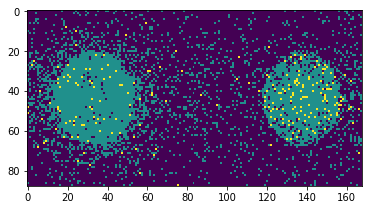

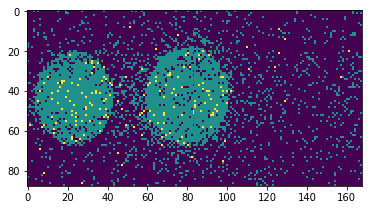

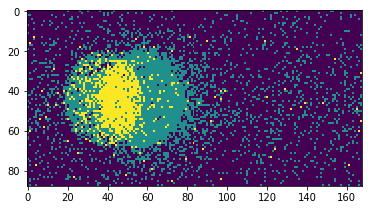

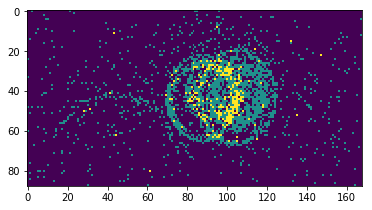

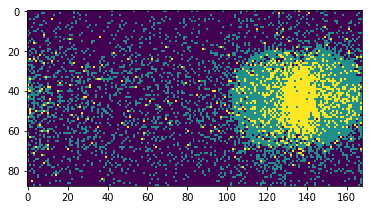

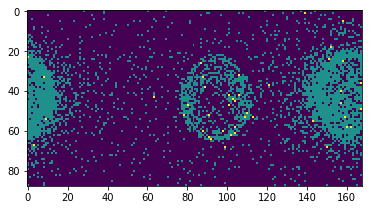

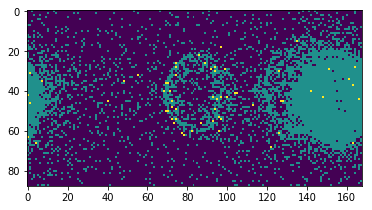

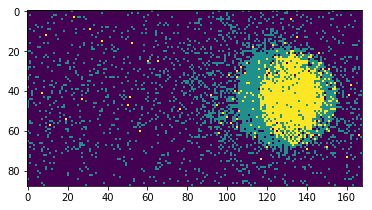

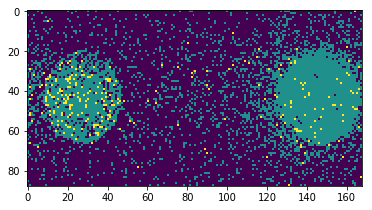

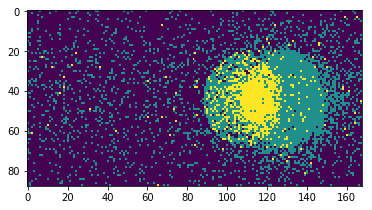

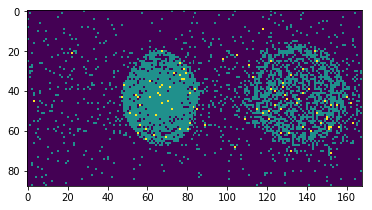

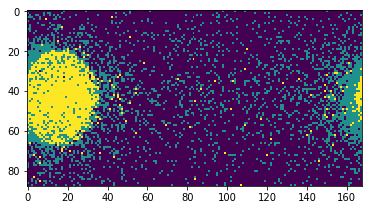

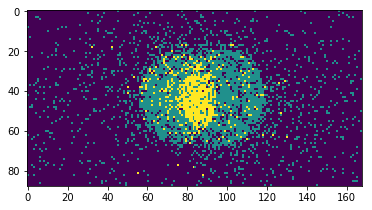

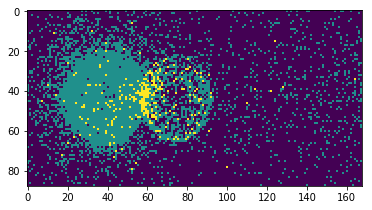

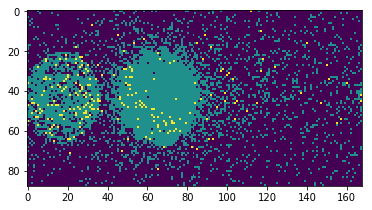

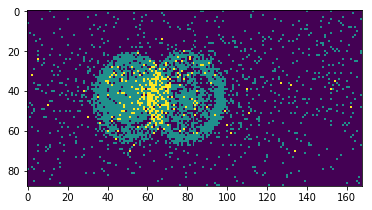

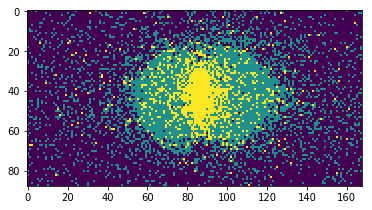

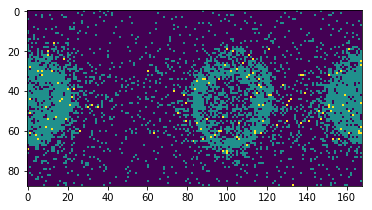

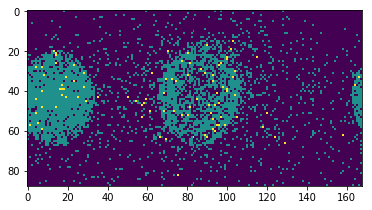

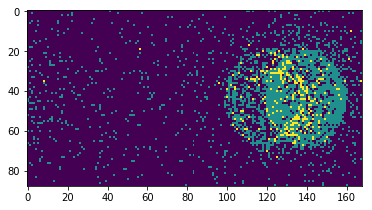

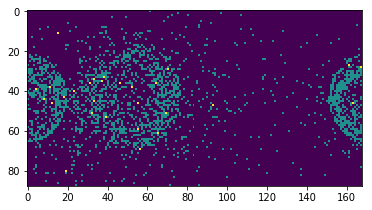

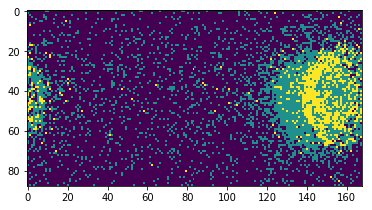

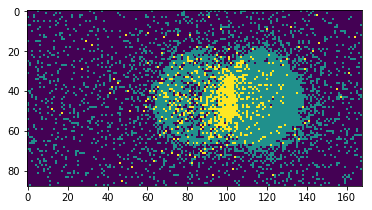

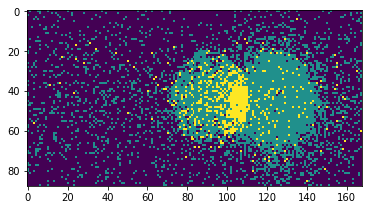

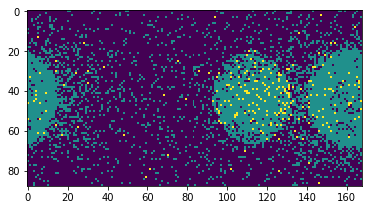

In [17]:
for idx,batch in enumerate(blob.train_loader):
    for idx in np.arange(0,batch[0].shape[0]):
        plt.imshow(batch[1][idx,:,:])
        plt.show()
    break

In [8]:
def forward(blob,train=True):
    """
    Args: blob should have attributes: net, criterion, softmax, data, label
    Returns: a dictionary of predicted labels, softmax, loss and accuracy
    """
    with torch.set_grad_enabled(train):
        # prediction
        data = torch.as_tensor(blob.data).cuda()
        data = data.permute(0,3,1,2) # I think we bring the "channel" before the spacial dimension here
        prediction = blob.net(data)
        
        # training
        loss,acc = -1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()
            label.requires_grad = False # because we don't train this, sav space
            loss = blob.criterion(prediction,label) # evaluate loss function
        blob.loss = loss
        
        #softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=1) # 1 is the C index
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        prediction = prediction.cpu().detach().numpy()
        
        return {
            'prediction': prediction,
            #'softmax':    softmax,
            'loss':       loss,
            'accuracy':   accuracy
        }

def backward(blob):
    blob.optimizer.zero_grad() # reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

In [10]:
def training_loop(blob,TRAIN_EPOCH):
    from utils import progress_bar

    TRAIN_EPOCH = 3.0 # one epoch is having processed all data once

    blob.net.train()
    epoch=0.
    iteration=0

    # start training
    while int(epoch+0.5) < TRAIN_EPOCH:
        print('Epoch',int(epoch+0.5),'Starting @',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))
        # create progressbar for this epoch
        progress = display(progress_bar(0,len(blob.train_loader)),display_id=True)
        for i,data in enumerate(blob.train_loader):
            blob.data,blob.label = data[0:2]
            # make prediction and measure avg error
            res = forward(blob,train=True)
            # back-propopagate
            backward(blob)
            # epoch update
            epoch += 1./len(blob.train_loader)
            iteration += 1
            blob.iteration = iteration

            # log/report
            blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
            blob.train_log.write()
            # once in a while, report
            if i==0 or (i+1)%10 == 0:
                message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
                progress.update(progress_bar((i+1),len(blob.train_loader),message))
            # more rarely, run validation
            if (i+1)%100 == 0:
                with torch.no_grad():
                    blob.net.eval()
                    test_data = next(iter(blob.test_loader))
                    blob.data,blob.label = test_data[0:2]
                    res = forward(blob,train=False)
                    blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                    blob.test_log.write()
                blob.net.train() # set back to training mode
            if (epoch >= TRAIN_EPOCH):
                break

        # final result of this epoch (not done yet)
        message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
        progress.update(progress_bar((i+1),len(blob.train_loader),message))

    blob.test_log.close()
    blob.train_log.close()    

In [11]:
# make network

class UCH2Net(torch.nn.Module):
    def __init__(self, num_class, momentum = 0.9):
        super(UCH2Net, self).__init__()
        
        # feature extractor CNN
        self._feature_ops = [
            # input: (N,88,168,2)
            
            # conv: 2 -> 16 ch, 3x3
            torch.nn.Conv2d(2,16,3,padding=1,stride=2), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16,momentum=momentum),
            # conv: 16 -> 32 ch, 3x3
            torch.nn.Conv2d(16,32,3,padding=1,stride=2), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32,momentum=momentum),
        ]
        self._feature = torch.nn.Sequential(*self._feature_ops)
        
        self._convT_ops = [
            # now increase again
            torch.nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
            torch.nn.ConvTranspose2d(16,num_class,3,stride=2,padding=1,output_padding=1),
        ]
        self._convT = torch.nn.Sequential(*self._convT_ops)
        
        #def weights_init(m):
        #    if isinstance(m, torch.nn.Conv2d):
        #        torch.nn.init.xavier_uniform_(m.weight)
        #        if m.bias is not None:
        #            #torch.nn.init.xavier_uniform(m.weight)
        #            torch.nn.init.xavier_uniform_(m.bias)
        #self._feature.apply(weights_init)

    
    def forward(self, x, show_shape=False):
        org = x
        if not show_shape:
            x = self._feature(x)
        else:
            print('Input shape', x.size())
            for block_ctr, op in enumerate(self._feature_ops):
                x = op(x)
                print('After block',block_ctr,x.size())
        
        if not show_shape:
            x = self._convT(x)
        else:
            print('Input shape', x.size())
            for block_ctr, op in enumerate(self._convT_ops):
                x = op(x)
                print('After block',block_ctr,x.size())
        
        x = x.permute(1,0,2,3) # (B,C,V,H) -> (C,B,V,H)
        nohit = torch.where(org[:,0,:,:] == 0., org[:,0,:,:]*1., org[:,0,:,:]*0.) # (B,V,H)
        x = torch.cat((nohit.unsqueeze(0), x)).permute(1,0,2,3) # concat along C, then (C,B,V,H) -> (B,C,V,H)
        
        if show_shape: print('After concat nohit info',x.size())
        
        return x

In [12]:
shapeTest = torch.as_tensor(np.stack([batch[1][0,:,:], batch[1][0,:,:]], -1))

# add the batch dimension, put the channel at second index
shapeTest = shapeTest.unsqueeze(0).permute(0,3,1,2)

print(shapeTest.shape)
print(type(shapeTest[0,0,0,0]))
print(shapeTest.type())
shapeTest = shapeTest.type(torch.FloatTensor)

shapeTestNet = UCH2Net(3)
shapeTestNet(shapeTest, show_shape=True);

torch.Size([1, 2, 88, 168])
<class 'torch.Tensor'>
torch.DoubleTensor
Input shape torch.Size([1, 2, 88, 168])
After block 0 torch.Size([1, 16, 44, 84])
After block 1 torch.Size([1, 16, 44, 84])
After block 2 torch.Size([1, 16, 44, 84])
After block 3 torch.Size([1, 32, 22, 42])
After block 4 torch.Size([1, 32, 22, 42])
After block 5 torch.Size([1, 32, 22, 42])
Input shape torch.Size([1, 32, 22, 42])
After block 0 torch.Size([1, 16, 44, 84])
After block 1 torch.Size([1, 3, 88, 168])
After concat nohit info torch.Size([1, 4, 88, 168])


In [14]:
class HitPixelCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(HitPixelCrossEntropyLoss,self).__init__()
        
        # cross entropy loss expects arguments
        # prediction = (B,C)
        # label      = (B)
        self._cel = torch.nn.CrossEntropyLoss()
        
    def forward(self,x,y):
        # x is (B,C,V,H) with B:batch-index, C:channel-index, V:vert-index, H:horz-index
        # y is (B,V,H)
        x1d = x.permute(1,0,2,3) # (B,C,V,H) -> (C,B,V,H)
        #print(x1d.size())
        x1d = x1d.view(x.shape[1],-1).permute(1,0) # merge V,H into B (cross entropy sums over C)
        y1d = y.view(-1) # merge H,V into B
        # so [x1d] = (B*H*V,C)
        #    [y1d] = (B*H*V)
        #print('x1d',x1d.shape)
        #print('y1d',y1d.shape)
        
        # where x1d[,0] == 1, we have no hit, so ignore information
        y1d = torch.where(x1d[:,0] == 1., y1d*0., y1d)
        #for i in np.arange(1,x1d.shape[1]-1):
        #    x1d[:,i] = torch.where(x1d[:,0] == 1., x1d[:,i]*0., x1d[:,i])
        x1d = torch.where(x1d == 1., x1d*0., x1d)
        
        return self._cel(x1d,y1d)
    
        #print('loss',loss.shape,loss)
        ## [loss] = (B*H*V)
        #totloss = torch.reshape(loss, y.shape).sum(0)
        #return totloss


In [15]:
blob=BLOB()
blob.net       = UCH2Net(3).cuda()
blob.criterion = HitPixelCrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters(),weight_decay=0.001) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1)
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

# for train
blob.train_loader=hybrid_loader_factory(batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)
# for validation
blob.test_loader =hybrid_loader_factory(batch_size=64, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.8, use_fraction=0.2)

In [16]:
blob.train_log, blob.test_log = CSVData('06-UCH2-log_train.csv'), CSVData('06-UCH2-log_test.csv')
training_loop(blob,5.)

Epoch 0 Starting @ 2019-04-17 21:59:24


Epoch 1 Starting @ 2019-04-17 22:00:54


Epoch 2 Starting @ 2019-04-17 22:02:24


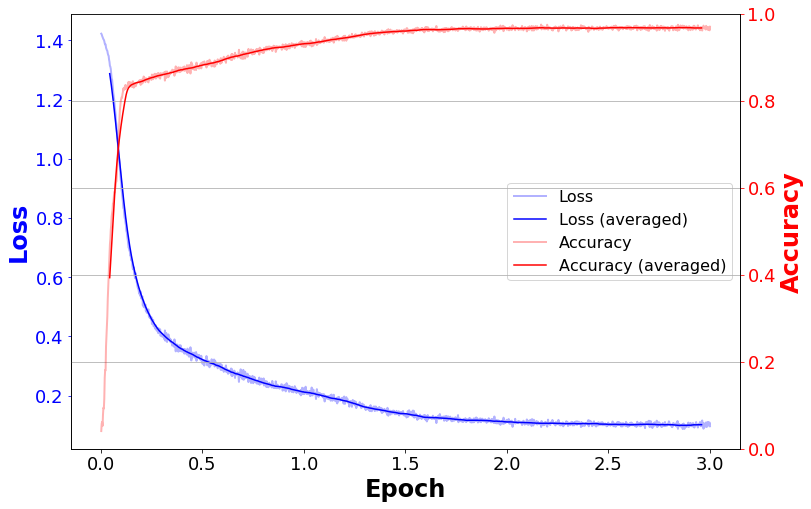

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
#test_log  = pd.read_csv(blob.test_log.name)

def moving_average(a,n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n-1):] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8), facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss',fontsize=24,fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
#plt.yscale('log')

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold', color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.)

lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

(64, 88, 168)
0


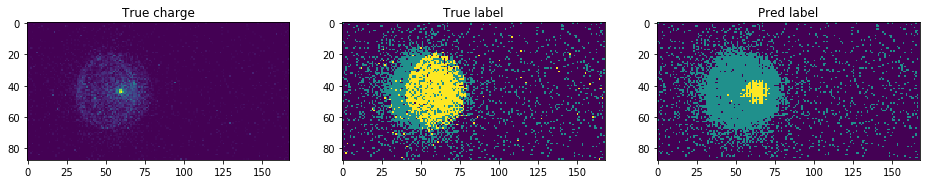

1


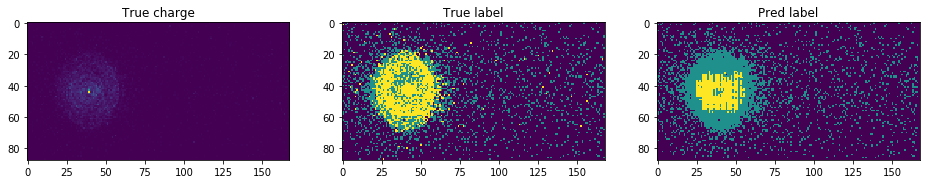

2


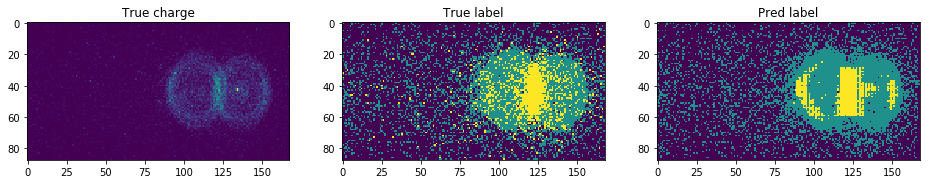

3


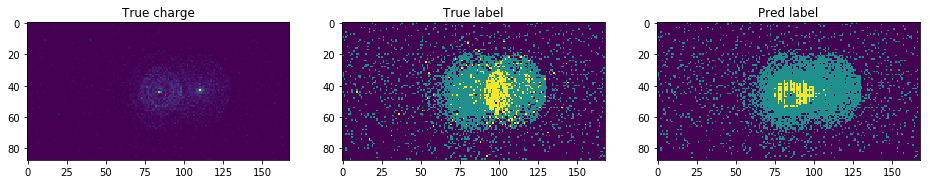

4


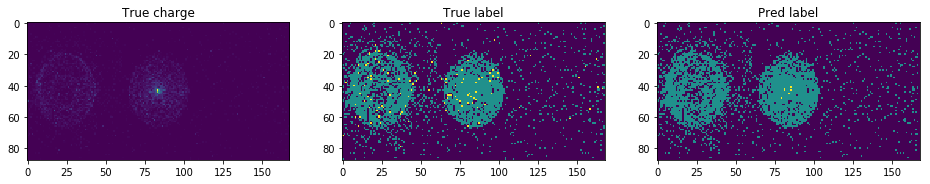

5


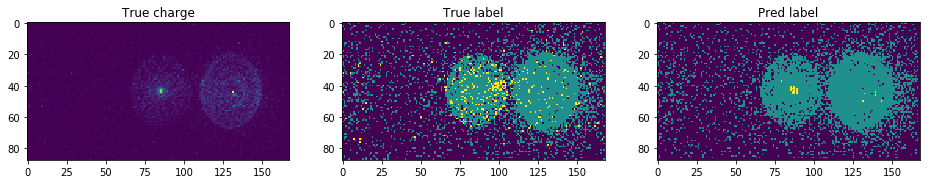

6


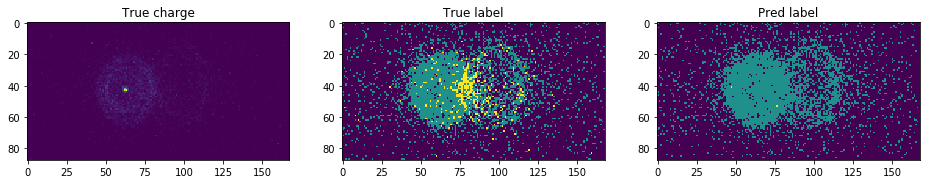

7


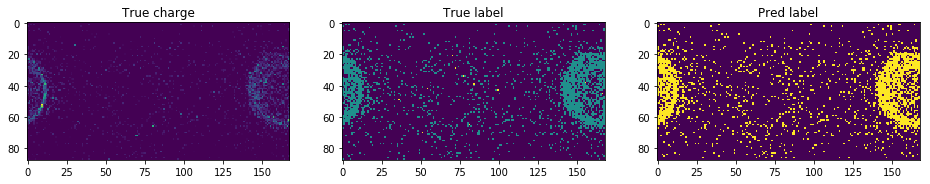

8


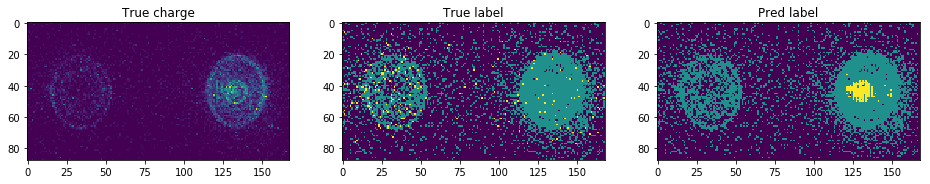

9


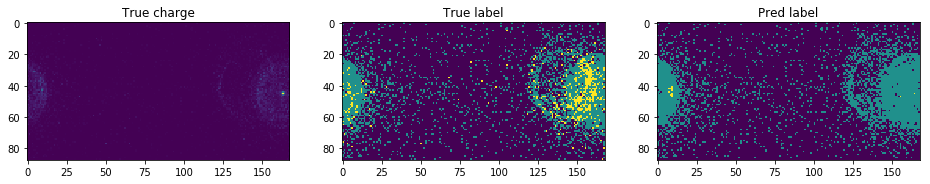

In [22]:
blob.net.eval() # eval mode
for i,data in enumerate(blob.train_loader):
    blob.data, blob.label = data[0:2]
    res = forward(blob,train=False)
    break

print(res['prediction'].shape)

for idx in np.arange(10):
    print(idx)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,8),facecolor='w')
    charg = blob.data[idx,:,:,0]
    pred  = res['prediction'][idx,:,:]
    pred = np.where(charg > 0., pred, 0.)
    ax1.imshow(charg)
    ax2.imshow(blob.label[idx,:,:])
    ax3.imshow(pred)
    ax1.set_title('True charge')
    ax2.set_title('True label')
    ax3.set_title('Pred label')
    plt.show()

## Multi-layer network

In [23]:
class UCNet(torch.nn.Module):
    def __init__(self, num_class, momentum = 0.9):
        super(UCNet, self).__init__()
        
        # feature extractor CNN
        self._feature_ops = [
            # input: (N,88,168,2)
            
            # conv: 2 -> 16 ch, 3x3
            torch.nn.Conv2d(2,16,3,padding=1), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(16,momentum=momentum),
            # conv: 16 -> 32 -> 32 ch, 3x3
            torch.nn.Conv2d(16,32,3,padding=1), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32,momentum=momentum),
            # conv: 32 -> 64 ch, 3x3
            torch.nn.Conv2d(32,64,3,padding=1), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64,momentum=momentum),
            # conv: 64 -> 128 ch, stride-2, 3x3
            torch.nn.Conv2d(64,128,3,stride=2,padding=1), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128,momentum=momentum),
            # conv: 128 -> 256 ch, stride-2, 3x3
            torch.nn.Conv2d(128,256,3,stride=2,padding=1), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256,momentum=momentum),
        ]
        self._feature = torch.nn.Sequential(*self._feature_ops)
        
        self._convT_ops = [
            # now increase again
            torch.nn.ConvTranspose2d(256,128,3,stride=2,padding=1,output_padding=1), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128,momentum=momentum),
            torch.nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1), torch.nn.ReLU(),
            torch.nn.BatchNorm2d(64,momentum=momentum),
            torch.nn.ConvTranspose2d(64,num_class,3,padding=1)
        ]
        self._convT = torch.nn.Sequential(*self._convT_ops)
        
        #def weights_init(m):
        #    if isinstance(m, torch.nn.Conv2d):
        #        torch.nn.init.xavier_uniform_(m.weight)
        #        if m.bias is not None:
        #            #torch.nn.init.xavier_uniform(m.weight)
        #            torch.nn.init.xavier_uniform_(m.bias)
        #self._feature.apply(weights_init)

    
    def forward(self, x, show_shape=False):
        org = x
        
        if not show_shape:
            x = self._feature(x)
        else:
            print('Input shape', x.size())
            for block_ctr, op in enumerate(self._feature_ops):
                x = op(x)
                print('After block',block_ctr,x.size())
        
        if not show_shape:
            x = self._convT(x)
        else:
            print('Input shape', x.size())
            for block_ctr, op in enumerate(self._convT_ops):
                x = op(x)
                print('After block',block_ctr,x.size())
        
        x = x.permute(1,0,2,3) # (B,C,V,H) -> (C,B,V,H)
        nohit = torch.where(org[:,0,:,:] == 0., org[:,0,:,:]*1., org[:,0,:,:]*0.) # (B,V,H)
        x = torch.cat((nohit.unsqueeze(0), x)).permute(1,0,2,3) # concat along C, then (C,B,V,H) -> (B,C,V,H)
        
        if show_shape: print('After concat nohit info',x.size())
        
        return x

In [24]:
blob=BLOB()
blob.net       = UCNet(3).cuda()
blob.criterion = HitPixelCrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters(),weight_decay=0.001) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1)
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

# for train
blob.train_loader=hybrid_loader_factory(batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)
# for validation
blob.test_loader =hybrid_loader_factory(batch_size=64, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.8, use_fraction=0.2)

In [27]:
# train

blob.train_log, blob.test_log = CSVData('06-UC-log_train.csv'), CSVData('06-UC-log_test.csv')
training_loop(blob,1.)

Epoch 0 Starting @ 2019-04-17 22:26:33


Epoch 1 Starting @ 2019-04-17 22:32:45


Epoch 2 Starting @ 2019-04-17 22:38:56


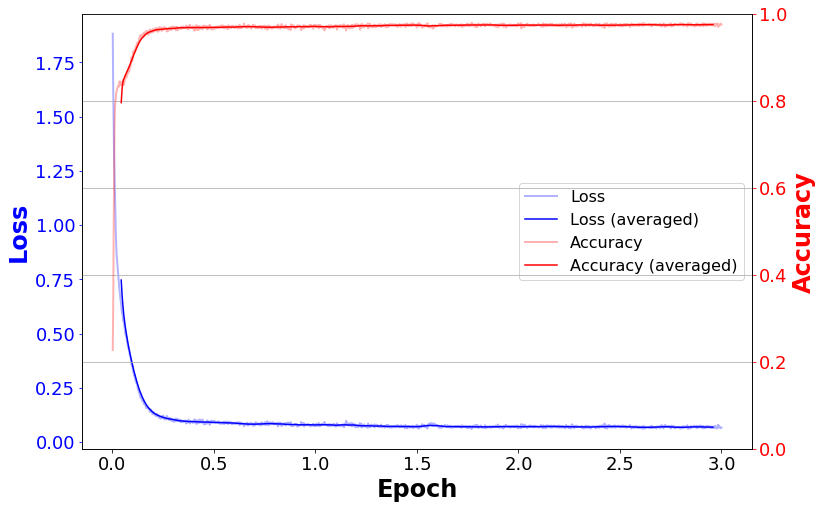

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
#test_log  = pd.read_csv(blob.test_log.name)

def moving_average(a,n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[(n-1):] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8), facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss',fontsize=24,fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)
#plt.yscale('log')

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold', color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.)

lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

(64, 88, 168)
0


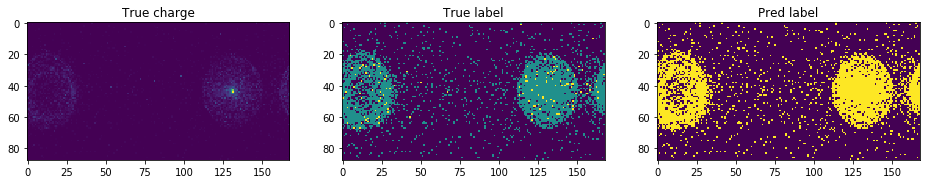

1


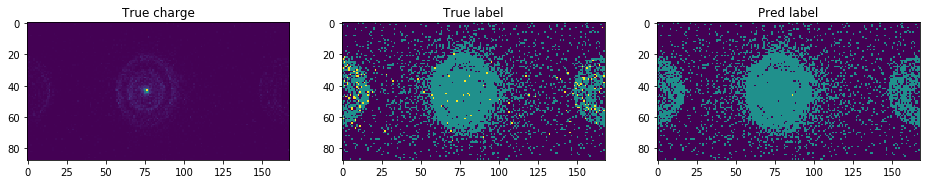

2


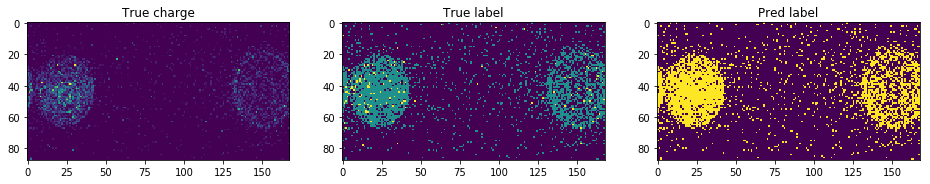

3


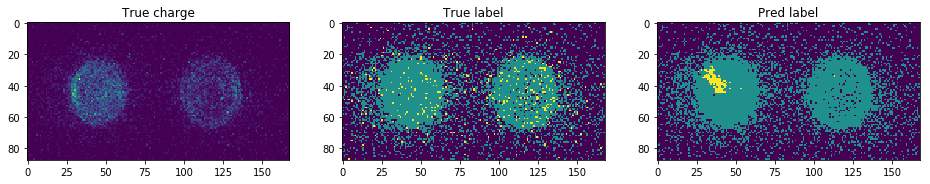

4


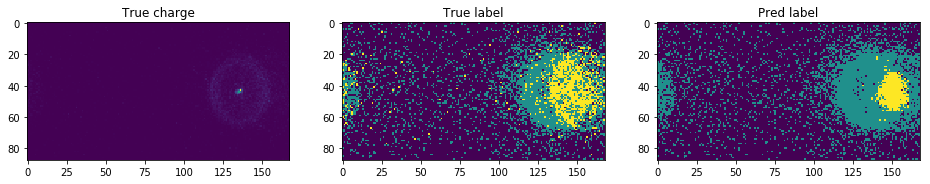

5


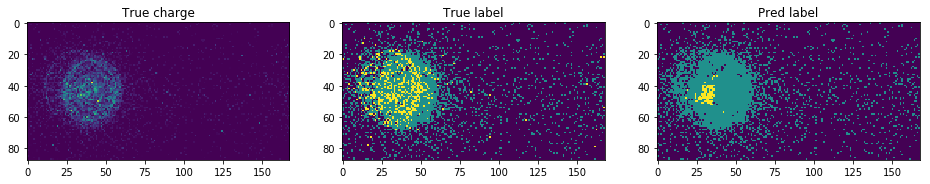

6


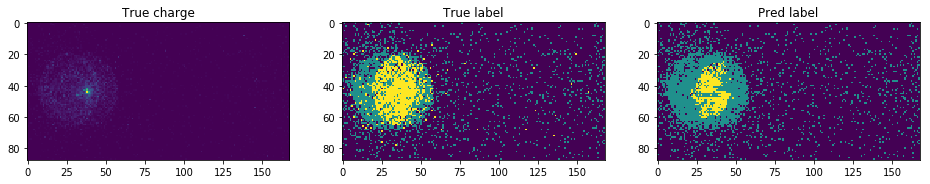

7


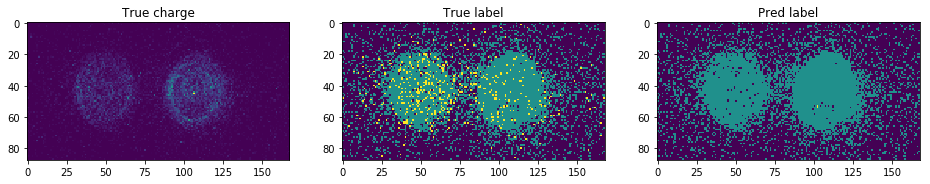

8


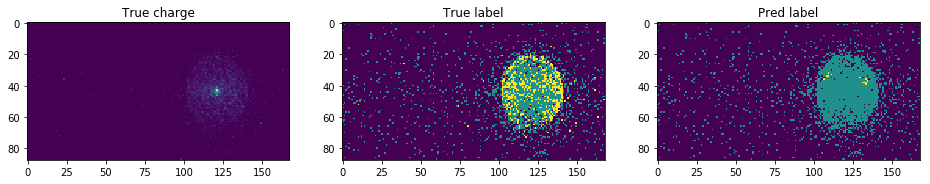

9


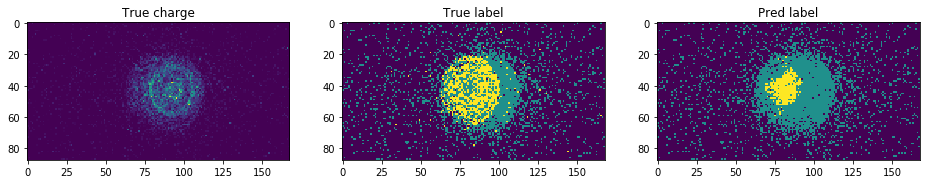

In [29]:
blob.net.eval() # eval mode
for i,data in enumerate(blob.train_loader):
    blob.data, blob.label = data[0:2]
    res = forward(blob,train=False)
    break

print(res['prediction'].shape)

for idx in np.arange(10):
    print(idx)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,8),facecolor='w')
    charg = blob.data[idx,:,:,0]
    pred  = res['prediction'][idx,:,:]
    pred = np.where(charg > 0., pred, 0.)
    ax1.imshow(charg)
    ax2.imshow(blob.label[idx,:,:])
    ax3.imshow(pred)
    ax1.set_title('True charge')
    ax2.set_title('True label')
    ax3.set_title('Pred label')
    plt.show()

(64, 88, 168)
0


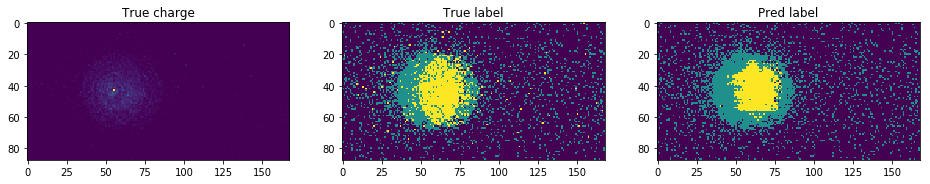

1


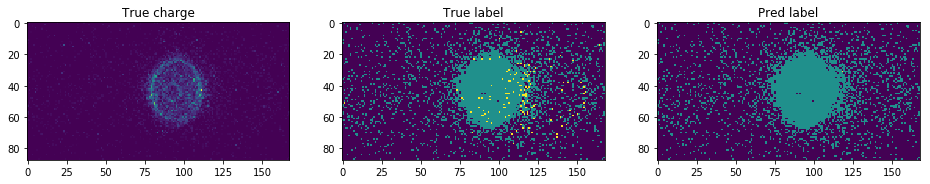

2


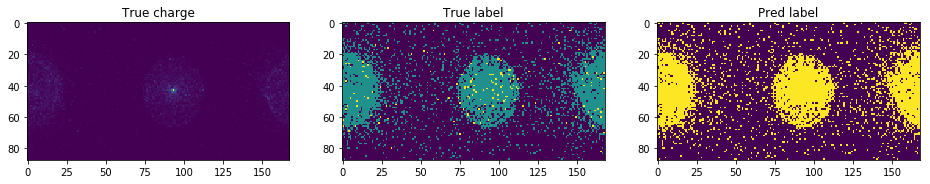

3


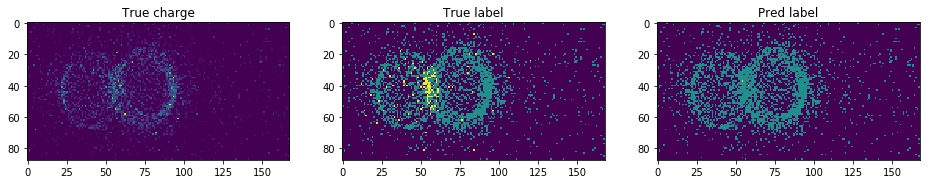

4


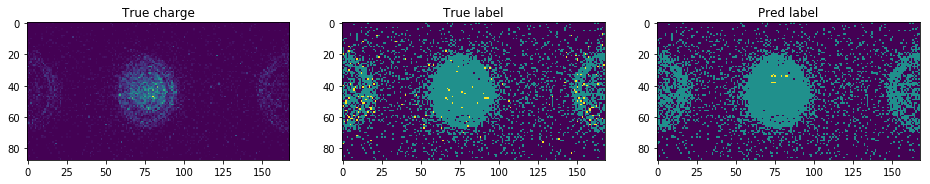

5


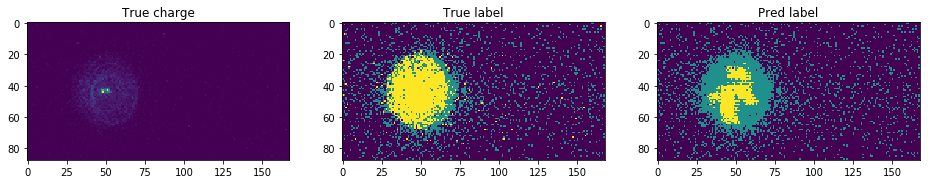

6


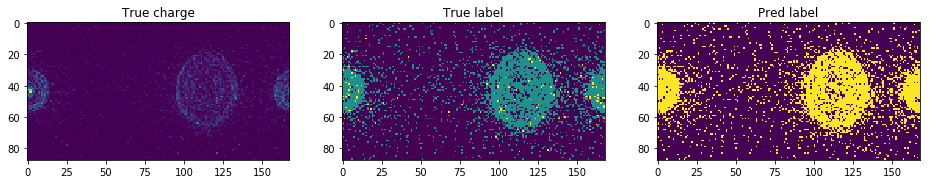

7


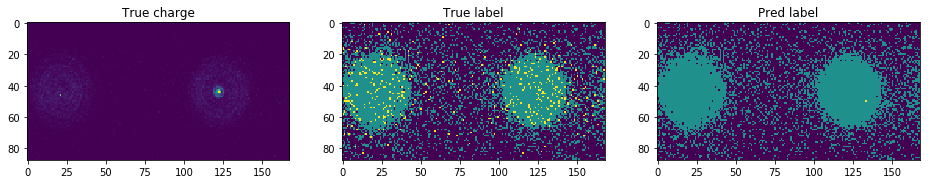

8


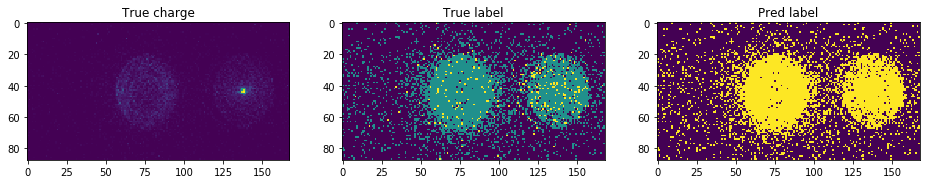

9


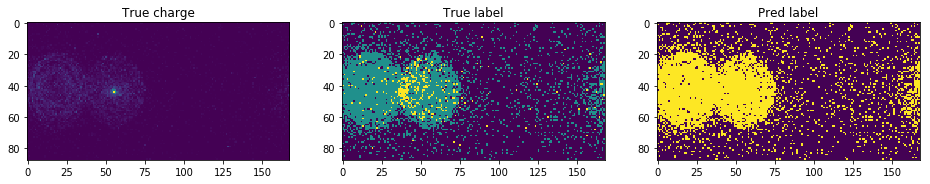

In [30]:
blob.net.eval() # eval mode
for i,data in enumerate(blob.test_loader):
    blob.data, blob.label = data[0:2]
    res = forward(blob,train=False)
    break

print(res['prediction'].shape)

for idx in np.arange(10):
    print(idx)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,8),facecolor='w')
    charg = blob.data[idx,:,:,0]
    pred  = res['prediction'][idx,:,:]
    pred = np.where(charg > 0., pred, 0.)
    ax1.imshow(charg)
    ax2.imshow(blob.label[idx,:,:])
    ax3.imshow(pred)
    ax1.set_title('True charge')
    ax2.set_title('True label')
    ax3.set_title('Pred label')
    plt.show()